##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
### a) print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 

In [7]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


**X and Y :** represents the geographical location where the crime happened

**Area_Command:** tells us the different geographical or territorial division within the jurisdiction where the crime took place

**NIBRSOffenseCode:** National Incident-Based Reporting System Codes are numerical codes used to categorize and describe different types of criminal offenses

**DayOfWeek:** the day of the week when the crime happened, like Sun, Mon, Tue etc. 

**Time:** hour of the day when the crime happened.

**VictimCount:** number of victims involved in the crime.

### b) Identify the input and target variables

**Input Variables:** X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time 

**Output Variable:** VictimCount

### c) what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [8]:
column_ranges = {}

for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    column_ranges[column] = (min_value, max_value)

for column, (min_value, max_value) in column_ranges.items():
    print(f"\033[1m{column}:\033[0m {min_value} to {max_value}")


X: -116.0 to -114.6255705
Y: 35.0684190000001 to 37.0000000000001
Area_Command: 0 to 11
NIBRSOffenseCode: 0 to 2
DayOfWeek: 0 to 6
Time: 0 to 23
VictimCount: 0 to 6


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns to normalize
columns_to_normalize = ['X', 'Y']

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the specified columns and transform the data
df_normalized = df.copy()  # Create a copy of the original DataFrame
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
df_normalized.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,0.663899,0.594478,0,0,0,0,0
1,0.552832,0.580495,1,1,1,1,0
2,0.623467,0.576165,2,1,2,0,1
3,0.563860,0.543189,3,1,1,2,2
4,0.599006,0.531973,4,1,1,3,0


I have normalized the X and Y values in the range of 0 - 1 using MinMaxScaler( ) to bring it closer to the values of other columns, but it didn't make much of a difference.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert the DataFrame to a PyTorch tensor
data_tensor = torch.tensor(df.values, dtype=torch.float32)

# Separate the input features (X) and target (Y)
X = data_tensor[:, :-1]  # Select all columns except the last one
Y = data_tensor[:, -1]   # Select the last column 'VictimCount'

# Define batch size
batch_size = 32

# Create training and testing datasets
dataset = TensorDataset(X, Y)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    inputs, outputs = batch
    print("Input shape:", inputs.shape)
    print("Output shape:", outputs.shape)
    break

# Ensure the output shape is (batch_size, 1)
outputs = outputs.unsqueeze(1)
print("Output shape:", outputs.shape)


Input shape: torch.Size([32, 6])
Output shape: torch.Size([32])
Output shape: torch.Size([32, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 
 

## <span style="font-size: 16px;">**Q: What is the proper loss function for this task?**</span>
<span style="font-size: 14px;">**A:** The proper loss function for this problem is Mean Squared Error (MSE).</span>


## <span style="font-size: 16px;">**Q: what should the size of the predicted output be?**</span>
<span style="font-size: 14px;">**A:** The size of the predicted output should be 1 numerical value</span>


## <span style="font-size: 16px;">**Q: explain your choice of architecture, including how many layers you will be using**</span>
<span style="font-size: 14px;">**A:** The common choice of architecture is to use feedforward neural network model (multi-layer perceptron or MLP)
    
Input Layer -> Hidden Layers -> Output Layer</span>


## <span style="font-size: 16px;">**Q: define an optimizer for training this model, choose a proper learning rate**</span>
<span style="font-size: 14px;">**A:** I have chosen Adam Optimizer for my model and 0.03 as learning rate</span>



### <span style="font-size: 14px;">Write a training loop that obtains a batch out of the training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.</span>

### <span style="font-size: 14px;">Write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the "MSE" error on the test data and print it.</span>

### <span style="font-size: 14px;">Is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and the number of layers to achieve the best accuracy and report it.</span>


In [11]:
import torch.nn as nn
import torch.optim as optim

input_size = 6  
hidden_size = 128
output_size = 1  
learning_rate = 0.03
num_epochs = 100

class DeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Create the model, loss function, and optimizer
model = DeepRegressionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs, targets = batch

        # Forward pass
        outputs = model(inputs)

        # Modify the shape of targets to (batch_size, 1)
        targets = targets.unsqueeze(1)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}')

# Evaluate the model on the test data
model.eval()
total_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)

        # Modify the shape of targets to (batch_size, 1)
        targets = targets.unsqueeze(1)

        loss = criterion(outputs, targets)
        total_loss += loss.item()

mean_loss = total_loss / len(test_loader)
print(f'Mean Test Loss: {mean_loss}')


Epoch [1/100] - Loss: 1.2875936031341553
Epoch [2/100] - Loss: 0.5405612587928772
Epoch [3/100] - Loss: 1.0480891466140747
Epoch [4/100] - Loss: 0.9180131554603577
Epoch [5/100] - Loss: 1.6173757314682007
Epoch [6/100] - Loss: 0.9384716749191284
Epoch [7/100] - Loss: 0.36190059781074524
Epoch [8/100] - Loss: 1.4042495489120483
Epoch [9/100] - Loss: 1.3866288661956787
Epoch [10/100] - Loss: 1.2998465299606323
Epoch [11/100] - Loss: 1.2176567316055298
Epoch [12/100] - Loss: 2.6233277320861816
Epoch [13/100] - Loss: 0.8802658915519714
Epoch [14/100] - Loss: 1.4575544595718384
Epoch [15/100] - Loss: 1.2194023132324219
Epoch [16/100] - Loss: 0.8631861805915833
Epoch [17/100] - Loss: 0.7319805026054382
Epoch [18/100] - Loss: 1.045519471168518
Epoch [19/100] - Loss: 1.9188278913497925
Epoch [20/100] - Loss: 1.1597455739974976
Epoch [21/100] - Loss: 1.6885662078857422
Epoch [22/100] - Loss: 0.6676391363143921
Epoch [23/100] - Loss: 0.8408709168434143
Epoch [24/100] - Loss: 0.9120165109634399
E

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

### a) How would you find the number of classes on the output data?
In this implementation I have directly assigned the number of victims to the number of classes. 


### b) How is the architecture different?
This is a classification model, where task 3 is a regression model. In classification model we are trying to categorize the incidents into one of the 7 classes where in regression model we are trying to predict the victim count. 


This neural network model consists a few linear models, activation functions etc. But a different Loss function 'Cross Entropy'. It also evaluates accuracy


### c) How is the loss function different?
Loss function here is Cross Entropy. Cross-entropy loss measures the dissimilarity between predicted probabilities and actual class labels, making it suitable for classification tasks, while mean squared error (MSE) measures the squared difference between predicted values and actual values, making it appropriate for regression tasks.

#### d) Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.

#### e) Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
#### f) Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

Below is the simple classification model built similar to the regression model. ref: https://ashleyycz.medium.com/mnist-digit-classification-in-pytorch-302476b34e4f

### Task 4.1

### Classification

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the input columns and the target column
input_cols = ["X", "Y", "Time", "Area_Command", "NIBRSOffenseCode", "DayOfWeek"]
output_col = "VictimCount"  # Assuming this is the original numeric column

# Create tensors for inputs and original numeric outputs
inputs = torch.tensor(df[input_cols].values, dtype=torch.float32)
original_outputs = torch.tensor(df[output_col].values, dtype=torch.float32)

# Define the number of classes (7 classes, VictimCount from 0 to 6)
num_classes = 7  # Update the number of classes

# Define batch size
batch_size = 25

# Create a DataLoader for the dataset
dataset = TensorDataset(inputs, original_outputs)  # Use original numeric outputs
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model architecture for classification into 7 classes
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Set hyperparameters
input_size = 6  # Number of input features
hidden_size = 128  # Number of units in each hidden layer
learning_rate = 0.001
num_epochs = 100

# Create the model, loss function, and optimizer
model = ClassificationModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Cross-Entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        inputs, targets = batch

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets.long())  # Use .long() for target values

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()} - Accuracy: {accuracy}')

# Evaluate the model on the test data
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy}')

Epoch [1/100] - Loss: 1.4455939531326294 - Accuracy: 0.4090909090909091
Epoch [2/100] - Loss: 1.1357821226119995 - Accuracy: 0.4772727272727273
Epoch [3/100] - Loss: 1.012437105178833 - Accuracy: 0.4681818181818182
Epoch [4/100] - Loss: 1.1176329851150513 - Accuracy: 0.5227272727272727
Epoch [5/100] - Loss: 1.2957384586334229 - Accuracy: 0.5272727272727272
Epoch [6/100] - Loss: 1.1602948904037476 - Accuracy: 0.4727272727272727
Epoch [7/100] - Loss: 0.9540772438049316 - Accuracy: 0.4681818181818182
Epoch [8/100] - Loss: 1.017166256904602 - Accuracy: 0.5045454545454545
Epoch [9/100] - Loss: 0.9128303527832031 - Accuracy: 0.44545454545454544
Epoch [10/100] - Loss: 0.9995610117912292 - Accuracy: 0.4909090909090909
Epoch [11/100] - Loss: 1.1542425155639648 - Accuracy: 0.4909090909090909
Epoch [12/100] - Loss: 0.9137724041938782 - Accuracy: 0.5136363636363637
Epoch [13/100] - Loss: 0.8444819450378418 - Accuracy: 0.5272727272727272
Epoch [14/100] - Loss: 1.038568377494812 - Accuracy: 0.459090

### Task 4.2

### Classification using Discretizing Victim Count

In the below model, I am discretizing the victim count column into 3 classes called Low, Medium and High inorder to increase the accuracy. 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the input columns and the target column
input_cols = ["X", "Y", "Time", "Area_Command", "NIBRSOffenseCode", "DayOfWeek"]
output_col = "VictimCount"  # Assuming this is the original numeric column

# Create tensors for inputs and original numeric outputs
inputs = torch.tensor(df[input_cols].values, dtype=torch.float32)
original_outputs = torch.tensor(df[output_col].values, dtype=torch.float32)

# Discretize 'VictimCount' into classes (e.g., 'Low', 'Medium', 'High')
thresholds = [1, 3]
class_labels = torch.zeros_like(original_outputs)
class_labels[original_outputs <= thresholds[0]] = 0  # Low class
class_labels[(original_outputs > thresholds[0]) & (original_outputs <= thresholds[1])] = 1  # Medium class
class_labels[original_outputs > thresholds[1]] = 2  # High class

# Define the number of classes
num_classes = 3

# Define batch size
batch_size = 32

# Create a DataLoader for the dataset
dataset = TensorDataset(inputs, class_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model architecture for classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Set hyperparameters
input_size = 6  # Number of input features
hidden_size = 128  # Number of units in each hidden layer
learning_rate = 0.001
num_epochs = 100

# Create the model, loss function, and optimizer
model = ClassificationModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Cross-Entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        inputs, targets = batch

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets.long())  # Use .long() for target values

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()} - Accuracy: {accuracy}')

# Evaluate the model on the test data
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy}')


Epoch [1/100] - Loss: 1.0733367204666138 - Accuracy: 0.759090909090909
Epoch [2/100] - Loss: 0.47995179891586304 - Accuracy: 0.8818181818181818
Epoch [3/100] - Loss: 0.3499149978160858 - Accuracy: 0.8818181818181818
Epoch [4/100] - Loss: 0.28095653653144836 - Accuracy: 0.8818181818181818
Epoch [5/100] - Loss: 0.3543579578399658 - Accuracy: 0.8818181818181818
Epoch [6/100] - Loss: 0.6407853364944458 - Accuracy: 0.8818181818181818
Epoch [7/100] - Loss: 0.3104253113269806 - Accuracy: 0.8818181818181818
Epoch [8/100] - Loss: 0.2704768478870392 - Accuracy: 0.8818181818181818
Epoch [9/100] - Loss: 0.5054503083229065 - Accuracy: 0.8818181818181818
Epoch [10/100] - Loss: 0.4254915714263916 - Accuracy: 0.8818181818181818
Epoch [11/100] - Loss: 0.6448277235031128 - Accuracy: 0.8818181818181818
Epoch [12/100] - Loss: 0.1982075721025467 - Accuracy: 0.8818181818181818
Epoch [13/100] - Loss: 0.29019695520401 - Accuracy: 0.8818181818181818
Epoch [14/100] - Loss: 0.38591447472572327 - Accuracy: 0.8818

### Task 4.3

### Classification by Oversampling
This model uses the oversampling method to increase the accuracy, I am using the builtin RandomForestClassifier here just to show that oversampling can be done in cases where the data is skewed

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler


# Define the input columns and the target column
input_cols = ["X", "Y", "Time", "Area_Command", "NIBRSOffenseCode", "DayOfWeek"]
output_col = "VictimCount"

# Create feature matrix (X) and target vector (y)
X = df[input_cols]
y = df[output_col]

# Initialize and apply RandomOverSampler to balance class distribution
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8743718592964824


## Task 5

### Reflect on your results



### Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?

* Task 3 involved training a deep regression model to predict a continuous numeric value, specifically "VictimCount." The model used multiple hidden layers and ReLU activation functions and was trained with the Mean Squared Error loss function. 

* Task 4, on the other hand, focused on classification, discretizing "VictimCount" into three classes (Low, Medium, High) and training a classification model using the Cross-Entropy loss function.

* Comparing results was a hard task, I have done 2 models for classification, 4.1 and 4.2. Where 4.1 does a regular classification which didn't yeild a good accuracy because of what they call Class Imbalance issue, where first few classes have more data samples and the last few classes have very few samples.

* How to solve class imbalance? 
There are multiple ways to solve class imbalance issue, some of them are oversampling, undersampling, class weighting, which will help solving this issue. 

* The way I solved it is by grouping/descritizing the classes, I have grouped class 0 and 1 as Low, 2 to 3 as Medium and 4+ as High victim count, which has helped me achieve better accuracy. 

You can see below that the data is skewed and it is not distributed properly or you can even call it class imbalance problem

In [15]:
value_counts = df['VictimCount'].value_counts()
value_counts

VictimCount
0    142
1    100
3     21
2      9
4      1
5      1
6      1
Name: count, dtype: int64

Below is the graphical representation of the distribution of output classes 

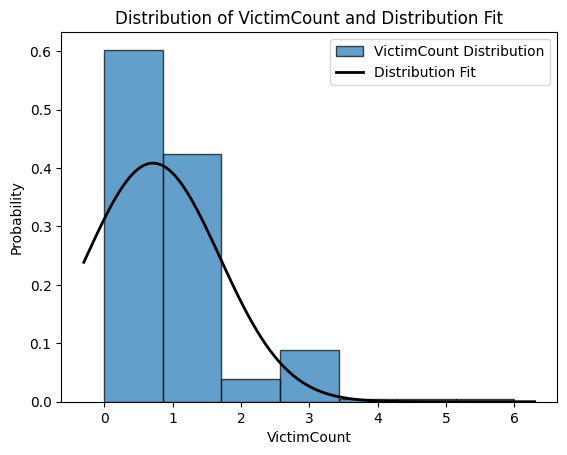

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract the VictimCount column from your DataFrame
victim_count = df["VictimCount"]

# Plot the histogram of VictimCount
plt.hist(victim_count, bins=7, density=True, edgecolor="black", alpha=0.7, label="VictimCount Distribution")

# Fit a normal distribution to the data
mu, std = norm.fit(victim_count)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label="Distribution Fit")

plt.xlabel("VictimCount")
plt.ylabel("Probability")
plt.title("Distribution of VictimCount and Distribution Fit")
plt.legend()
plt.show()


### Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

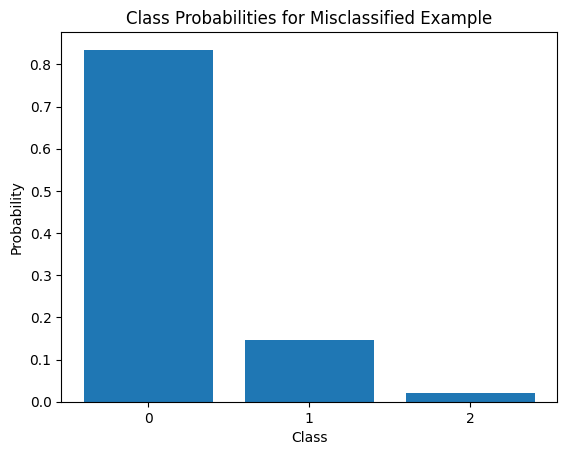

Misclassified Example:
Predicted Class: 0
Correct Class: 1.0


In [17]:
import matplotlib.pyplot as plt

# Define a function to find a misclassified example
def find_misclassified_example(model, test_loader):
    model.eval()
    misclassified_example = None

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(targets)):
                if predicted[i] != targets[i]:
                    misclassified_example = {
                        "inputs": inputs[i],
                        "predicted_class": predicted[i],
                        "correct_class": targets[i],
                        "class_probabilities": torch.softmax(outputs[i], dim=0)
                    }
                    break  # Break on the first misclassification found

            if misclassified_example is not None:
                break

    return misclassified_example

# Find a misclassified example
misclassified_example = find_misclassified_example(model, test_loader)

if misclassified_example is not None:
    inputs = misclassified_example["inputs"]
    predicted_class = misclassified_example["predicted_class"]
    correct_class = misclassified_example["correct_class"]
    class_probabilities = misclassified_example["class_probabilities"]

    # Create a bar chart to visualize class probabilities
    classes = [str(i) for i in range(num_classes)]  # Assuming class labels are integers 0 to num_classes-1
    plt.bar(classes, class_probabilities)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Class Probabilities for Misclassified Example')
    plt.show()

    print(f'Misclassified Example:')
    print(f'Predicted Class: {predicted_class}')
    print(f'Correct Class: {correct_class}')
else:
    print('No misclassified examples found.')


## Task 6: Exploring the patterns in raw data


#### Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?

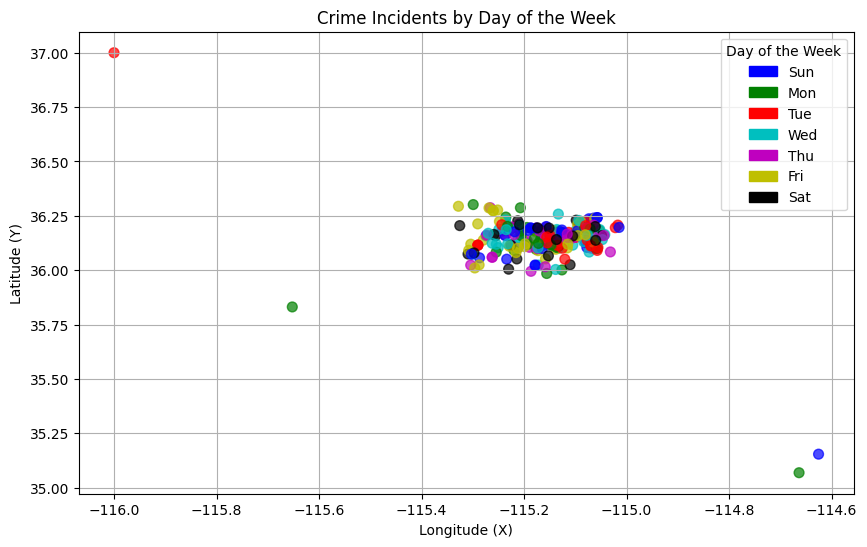

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define a color map for different days of the week
day_of_week_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Map day of the week values to colors in df_normalized
df['DayOfWeekColor'] = df['DayOfWeek'].apply(lambda day: day_of_week_colors[day])

# Scatter plot using data from df_normalized
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeekColor'], s=50, alpha=0.7)

# Create legend handles
legend_handles = [mpatches.Patch(color=c, label=d) for c, d in zip(day_of_week_colors, day_names)]

# Customize the plot
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')

# Use the legend_handles to create the legend
plt.legend(handles=legend_handles, title='Day of the Week')

plt.grid(True)

# Show the plot
plt.show()


The graph shows that the crimes are happening around the same area of location -115.2, 36 and the day of the week doesn't have much impact but majority of the crimes happening on weekdays

#### Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?

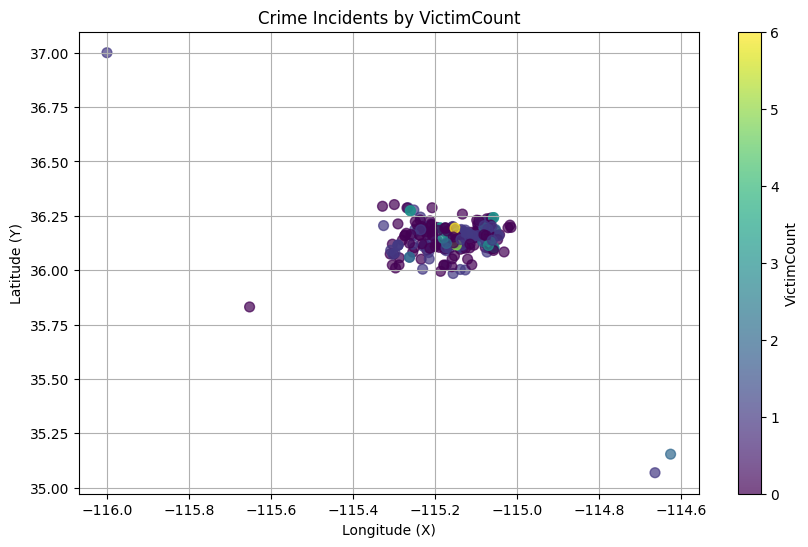

In [19]:
import matplotlib.pyplot as plt

# Scatter plot with color indicating the number of persons involved
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=50, alpha=0.7)

# Add colorbar to show the mapping of colors to VictimCount values
cbar = plt.colorbar(scatter)
cbar.set_label('VictimCount')

# Customize the plot
plt.title('Crime Incidents by VictimCount')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.grid(True)

# Show the plot
plt.show()


Crimes are more where 0 or 1 victims are involved and all the crimes are happening around the same area around -115.2, 36.25

#### Use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?

In [20]:
import pandas as pd

# Assuming df_normalized contains the data
day_counts = df_normalized['DayOfWeek'].value_counts().sort_index()

# Create a DataFrame for easier analysis and display
day_counts_df = pd.DataFrame({'DayOfWeek': day_counts.index, 'CrimeCount': day_counts.values})

# Sort by the number of crimes reported
sorted_day_counts = day_counts_df.sort_values(by='CrimeCount', ascending=False)

# Display the days with the most frequent crimes
print(sorted_day_counts)


   DayOfWeek  CrimeCount
4          4          51
3          3          44
5          5          43
0          0          40
1          1          37
2          2          32
6          6          28


Day 4 has the most crimes reported